# Model ROC curve, speed test, grad-CAM map test

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from PIL import Image
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.resnet import resnet34, resnet50, resnet101, resnet152
from torchvision.models.densenet import densenet121, densenet161, densenet169, densenet201
from torchvision.models.vgg import vgg19
import time
from copy import deepcopy
class MainModel(nn.Module):

    def __init__(self, arch, num_classes, pretrained=False):
        super().__init__()
        self.arch = arch
        model = globals()[arch](pretrained=pretrained)
        if arch.startswith('resnet'):
            n_feat = model.fc.in_features
            model.fc = nn.Sequential()
        elif arch.startswith('densenet'):
            n_feat = model.classifier.in_features
            model.classifier = nn.Sequential()
        elif arch.startswith('vgg'):
            n_feat = 1000
            model.fc = nn.Sequential()
        else:
            raise Exception('unkown architecture')
        self.feature = model
        self.fc = nn.Linear(n_feat, num_classes)

    def forward(self, x):
        feat = self.feature(x)
        logit = self.fc(feat)
        return logit
ct_mean = 0.188
ct_std = 0.315
def transform(dir):
    trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([ct_mean], [ct_std], inplace=True)
    ])
    return trans(
        Image.open(dir)
        # One, a single image. Three, 3 channels. -1 keeps original.
        # (1,3,256.256)
    ).expand(1, 3, 256, 256)

In [2]:
labels = pd.read_csv('../label.csv')
labels = labels.values

In [3]:
dn201 = MainModel('densenet201', 6, True)
dn201.load_state_dict(torch.load('densenet201_nw_pretrained/dn201_nw_16.pt'))
dn201.eval()

MainModel(
  (feature): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0

In [4]:
from argparse import Namespace
from skimage.io import imsave, imread
import os

In [5]:
np.random.shuffle(labels)

In [6]:
# test if this method is equal to transform
image = imread('images/bbec5b7d8.png')
image = torch.tensor(image[None, None, ...], dtype=torch.float32) / 255
image = (image - ct_mean) / ct_std
image = image.expand(-1, 3, -1, -1)
# ind = torch.tensor([[2]])
a = ((image == transform('images/bbec5b7d8.png'))+0)

FileNotFoundError: No such file: '/home/ec2-user/project/images/bbec5b7d8.png'

In [7]:
p = dn201(image)[0].detach().numpy()

NameError: name 'image' is not defined

In [8]:
from sklearn.metrics import roc_curve

In [9]:
def get_dataset():
    data_dir='..'
    data_dict = np.load(os.path.join('data.npy'), allow_pickle=True).item()
    data = []
    for k in data_dict:
        data.append((k, data_dict[k]))
    rs = np.random.RandomState(1)
    rs.shuffle(data)  # random shuffle
    N_train = int(0.85 * len(data))  # train test split
    data_train = data[:N_train]
    data_test = data[N_train:]
    # construct datasets
    dataset_train = CTDataset(data_dir, data_train)
    dataset_test = CTDataset(data_dir, data_test, True)
    return dataset_train, dataset_test
class CTDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, data, is_test=False):
        self.data_dir = data_dir
        self.data = data
        if is_test:
            # test
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([ct_mean], [ct_std], inplace=True)
            ])
        else:
            # train
            # data augmentation
            # random flip
            # random affine
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomAffine(degrees=10, translate=(0.02, 0.02)),
                transforms.ToTensor(),
                transforms.Normalize([ct_mean], [ct_std], inplace=True)
            ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_id, label = self.data[idx]
        image = Image.open(os.path.join('../images_nw', '%s.png' % img_id))  # load image
        image = self.transform(image).expand(3, -1, -1)
        return image, np.array(label, dtype=np.float32)
_, test_d = get_dataset()
test_d = torch.utils.data.DataLoader(test_d, batch_size=30, shuffle=False, pin_memory=False, drop_last=False)

In [10]:
def test(model, test_loader):
    ps = []
    labels = []
    
    model.eval()
    for i, (image, label) in enumerate(test_loader):
        labels.append(label)
        with torch.no_grad():
            logit = model(image)
            p = torch.sigmoid(logit)
            ps.append(p.cpu())
    ps = torch.cat(ps, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    return (ps, labels)

ps, labels = test(dn201, test_d)

In [134]:
resnet_model = MainModel('resnet101', 6, True)
resnet_model.load_state_dict(torch.load('resnet101/model_resnet101.pt'))
resnet_model.eval()


MainModel(
  (feature): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [ ]:
resps, reslabels = test(resnet_model , test_d)

In [258]:
# print(type(ps[0][0]))

In [262]:
# print(labels.shape)
# print(ps.shape)
# labels = labels.astype('int')
# print(labels.shape, ps.shape)
print(np.unique(labels))
l2 = labels.astype('int')

[0. 1.]


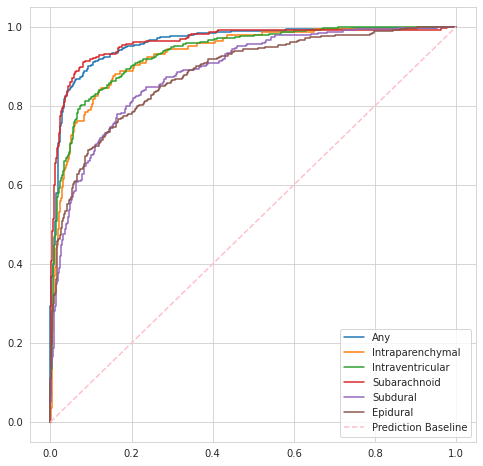

In [14]:
st = [
    'Any',
    'Intraparenchymal',
    'Intraventricular',
    'Subarachnoid',
    'Subdural',
    'Epidural'
]
rx = np.linspace(0,1,100)
ry = rx

plt.figure(figsize=(8,8))
for i in range(6):
    x, y, t = roc_curve(labels[:, i], ps[:, i])
    plt.plot(x,y, label=st[i])

plt.plot(rx,ry, linestyle='--', c='pink', label='Prediction Baseline')

plt.legend(loc='lower right')

In [13]:
import seaborn as sns
sns.set_style('whitegrid')

In [269]:
ps_cp = ps.copy()

In [272]:
ps.shape

(1335, 6)

In [276]:
a,b,c = roc_curve(labels.flatten(), ps.flatten(), pos_label=2)
# type(ps.max())

In [230]:
a = np.random.randn(1335,6)

In [231]:
a[a<0] = 0

In [232]:
a[a>1] = 1

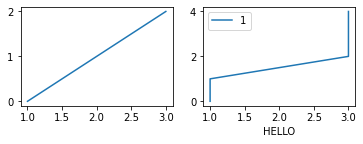

In [21]:
plt.subplot(2,2,1)
plt.plot([1,2,3],[0,1,2], label='2')

plt.subplot(2,2,2)
plt.plot([1,1,3,3],[0,1,2,4], label='1')

plt.xlabel('HELLO')
plt.legend()

In [49]:
sns.set_style('whitegrid')

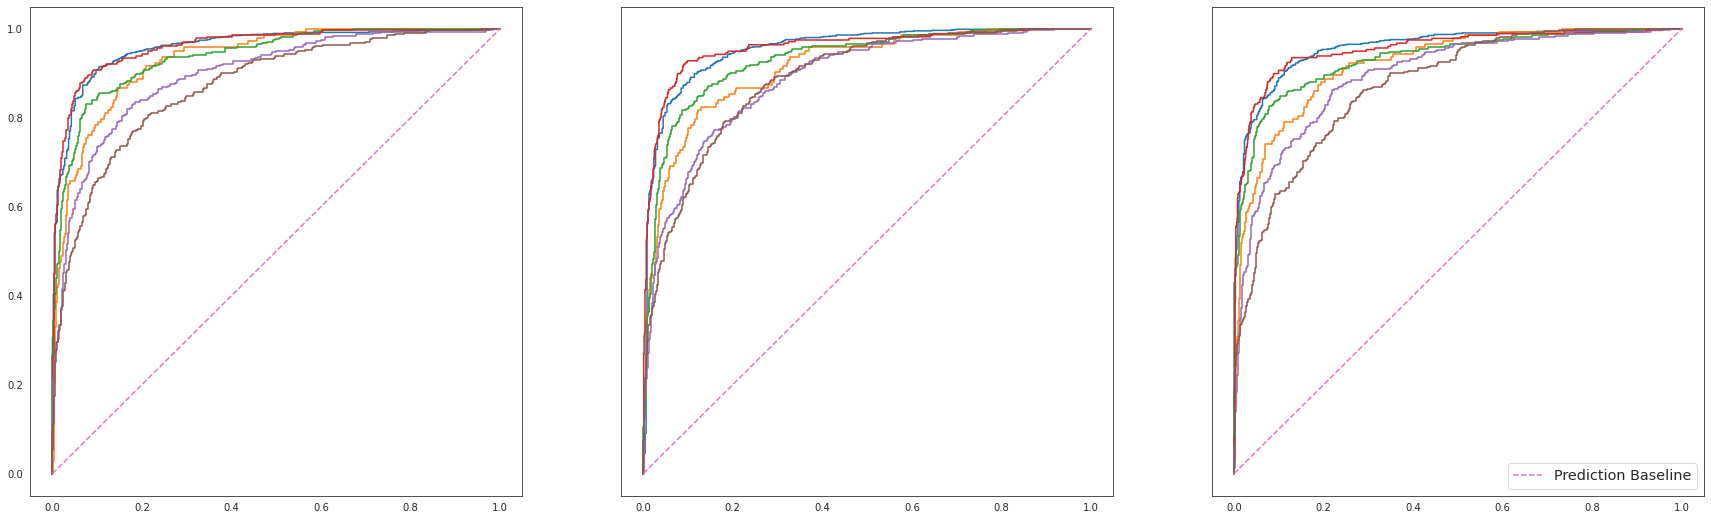

In [238]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(30, 9))
# fig.text(0.5, 0.07, 'common X', ha='center')
# fig.text(0.07, 0.5, 'common Y', va='center', rotation='vertical')

# .plot([1,1,2,3], [2,2,1,2])
st = [
    'Any',
    'Intraparenchymal',
    'Intraventricular',
    'Subarachnoid',
    'Subdural',
    'Epidural'
]

rx = np.linspace(0,1,100)
ry = rx

# for i in range(6):
#     x, y, t = roc_curve(labels[:, i], ps[:, i])
#     plt.plot(x,y,st[i])
    
for i in range(6):
    x, y, t = roc_curve(labels[:, i], ps[:, i])
    ax[0].plot(x,y)
ax[0].plot(rx,ry, linestyle='--')
    
for i in range(6):
    x, y, t = roc_curve(vgglabels[:, i], vggps[:, i])
    ax[1].plot(x,y)
ax[1].plot(rx,ry, linestyle='--')
    
    
for i in range(6):
    x, y, t = roc_curve(reslabels[:, i], resps[:, i])
    ax[2].plot(x,y)
ax[2].plot(rx,ry, linestyle='--', label='Prediction Baseline')


    



plt.legend(loc='lower right',fontsize='x-large')
# # handles, labels = ax.get_legend_handles_labels()
# # fig.legend(handles, labels, loc='upper center')


In [236]:
sns.set_style('white')

<br>

<br>

# Below is model speed test

<br>

In [52]:
# # # # # # # # # #
# MODEL NAMES # # # 
# # # # # # # # # # 

# dn201
# resnet_model
# vgg19_model


In [72]:
# dn201.eval()

In [100]:
df = pd.read_csv('../label.csv')
df = df['ID'].values

In [103]:
np.random.shuffle(df)

In [68]:
image_ids = df[:500]

In [92]:
t = []

for iid in image_ids:
    iname = iid + '.png'
    pa = transform('../images/'+iname)
    
    st = time.time()
    vgg19_model(pa)
    et = time.time()
    t.append(et-st)



In [93]:
len(t)

500

In [94]:
np.mean(t)

0.14148847198486328

In [97]:
np.mean(t) - min(t)

0.011295715332031248

<br>

# Grad-CAM Saliency Map

In [105]:
df[0]

'64edc023a'

In [106]:
transform('../images/' + df[0] + '.png')

tensor([[[[-0.5968, -0.5968, -0.5968,  ..., -0.5968, -0.5968, -0.5968],
          [-0.5968, -0.5968, -0.5968,  ..., -0.5968, -0.5968, -0.5968],
          [-0.5968, -0.5968, -0.5968,  ..., -0.5968, -0.5968, -0.5968],
          ...,
          [-0.5968, -0.5968, -0.5968,  ..., -0.5968, -0.5968, -0.5968],
          [-0.5968, -0.5968, -0.5968,  ..., -0.5968, -0.5968, -0.5968],
          [-0.5968, -0.5968, -0.5968,  ..., -0.5968, -0.5968, -0.5968]],

         [[-0.5968, -0.5968, -0.5968,  ..., -0.5968, -0.5968, -0.5968],
          [-0.5968, -0.5968, -0.5968,  ..., -0.5968, -0.5968, -0.5968],
          [-0.5968, -0.5968, -0.5968,  ..., -0.5968, -0.5968, -0.5968],
          ...,
          [-0.5968, -0.5968, -0.5968,  ..., -0.5968, -0.5968, -0.5968],
          [-0.5968, -0.5968, -0.5968,  ..., -0.5968, -0.5968, -0.5968],
          [-0.5968, -0.5968, -0.5968,  ..., -0.5968, -0.5968, -0.5968]],

         [[-0.5968, -0.5968, -0.5968,  ..., -0.5968, -0.5968, -0.5968],
          [-0.5968, -0.5968, -

In [ ]:
class GradCAM(nn.Module):

    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.eval()

    def forward(self, x, ind):
        feat, logit = self.model_forward(x)
        logit = torch.gather(logit, 1, ind)
        grad = torch.autograd.grad(logit.sum(), feat)[0]
        with torch.no_grad():
            weights = grad.mean((2, 3), keepdim=True)  # N x C x 1 x 1
            cam = (weights * feat).sum(1, keepdim=True)  # N x 1 x h x w
            cam = F.relu(cam)
            cam = F.interpolate(cam, x.shape[2:], mode='bilinear', align_corners=True)  # N x 1 x H x W
            cam = cam - cam.min()
            cam = cam / cam.max()
        return cam

    def model_forward(self, x):
        m = self.model.feature
        print(m)
        if self.model.arch.startswith('resnet'):
            with torch.no_grad():
                x = m.conv1(x)
                x = m.bn1(x)
                x = m.relu(x)
                x = m.maxpool(x)
                x = m.layer1(x)
                x = m.layer2(x)
                x = m.layer3(x)
                x = m.layer4(x)
            feat = x
            feat.requires_grad = True
            x = F.adaptive_avg_pool2d(feat, (1, 1))
            x = torch.flatten(x, 1)
            logit = self.model.fc(x)
        elif self.model.arch.startswith('densenet'):
            with torch.no_grad():
                feat = m.features(x)
                feat = F.relu(feat, inplace=True)
            feat.requires_grad = True
            out = F.adaptive_avg_pool2d(feat, (1, 1))
            out = torch.flatten(out, 1)
            logit = self.model.fc(out)
        else:
            raise Exception('unkown architecture')
        return feat, logit


In [107]:
def jet(image):
    n = 4 * image[:, :1]
    r = torch.clamp(torch.min(n-1.5,-n+4.5), 0, 1)
    g = torch.clamp(torch.min(n-0.5,-n+3.5), 0, 1)
    b = torch.clamp(torch.min(n+0.5,-n+2.5), 0, 1)
    return torch.cat((r,g,b), 1)


In [119]:
a = resnet_model

ModuleAttributeError: 'MainModel' object has no attribute 'clone'

In [156]:
def main(opts):
    # load image and convert to tensor
    image = imread(os.path.join(opts.data_dir, 'images', '%s.png' % opts.img_id))
#     image = transform(os.path.join(opts.data_dir, 'images', '%s.png' % opts.img_id))
    image = torch.tensor(image[None, None, ...], dtype=torch.float32) / 255
    image = (image - ct_mean) / ct_std
    image = image.expand(-1, 3, -1, -1)
    ind = torch.tensor([[opts.ind]])

    model = dn201

    # Grad CAM
    grad_cam = GradCAM(model)
    cam = grad_cam(image, ind)
    # output image with cam
    cam = jet(cam)
    image = torch.clamp(image * ct_std + ct_mean, 0, 1)
    imsave('gradCAM/%s.png' % opts.img_id, np.around(image[0,0].cpu().numpy()*255).astype(np.uint8))
    image = image + cam
    image = np.moveaxis(image[0].cpu().numpy(), 0, 2)
    image = image / image.max()
    image = np.around(image*255).astype(np.uint8)
    imsave('gradCAM/%s-cam.png' % opts.img_id, image)


In [158]:
if __name__ == '__main__':
    opts = Namespace(
        data_dir = '../',
        use_gpu = False,
        arch = 'densenet201',
        img_id = '6b2556543',
        ind = 0
    )
    main(opts)

In [114]:
class GradCAM(nn.Module):

    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.eval()

    def forward(self, x, ind):
        feat, logit = self.model_forward(x)
        logit = torch.gather(logit, 1, ind)
        grad = torch.autograd.grad(logit.sum(), feat)[0]
        with torch.no_grad():
            weights = grad.mean((2, 3), keepdim=True)  # N x C x 1 x 1
            cam = (weights * feat).sum(1, keepdim=True)  # N x 1 x h x w
            cam = F.relu(cam)
            cam = F.interpolate(cam, x.shape[2:], mode='bilinear', align_corners=True)  # N x 1 x H x W
            cam = cam - cam.min()
            cam = cam / cam.max()
        return cam

    def model_forward(self, x):
        m = self.model.feature
        if self.model.arch.startswith('resnet'):
            with torch.no_grad():
                x = m.conv1(x)
                x = m.bn1(x)
                x = m.relu(x)
                x = m.maxpool(x)
                x = m.layer1(x)
                x = m.layer2(x)
                x = m.layer3(x)
                x = m.layer4(x)
            feat = x
            feat.requires_grad = True
            x = F.adaptive_avg_pool2d(feat, (1, 1))
            x = torch.flatten(x, 1)
            logit = self.model.fc(x)
        elif self.model.arch.startswith('densenet'):
            with torch.no_grad():
                feat = m.features(x)
                feat = F.relu(feat, inplace=True)
            feat.requires_grad = True
            out = F.adaptive_avg_pool2d(feat, (1, 1))
            out = torch.flatten(out, 1)
            logit = self.model.fc(out)
        elif self.model.arch.startswith('vgg'):
            with torch.no_grad():
                feat = m.features(x)
                feat = F.relu(feat, inplace=True)
            feat.requires_grad = True
            out = F.adaptive_avg_pool2d(feat, (1, 1))
            out = torch.flatten(out, 1)
            logit = self.model.fc(out)
        else:
            raise Exception('unkown architecture')
        return feat, logit


In [123]:
df[1]

'7c0434e73'

In [136]:
ct_std

0.315

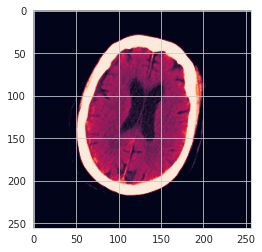

In [151]:
plt.imshow(plt.imread('../images/6b2556543.png'))

In [161]:
df[4]

'631d342a4'

In [147]:
hhh = pd.read_csv('../label.csv')

In [163]:
hhh[hhh['ID'] == '6b2556543']

,ID,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
4830,6b2556543,1,0,0,0,1,1


In [164]:
vgg19_model

MainModel(
  (feature): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (1

In [165]:
v2t = MainModel('vgg19', 6, True)
v2t.load_state_dict(torch.load('vgg19/model_vgg19.pt'))

<All keys matched successfully>

In [167]:
# dn201

In [184]:
csv = pd.read_csv('../label.csv')

In [191]:
df[25]

'c33907044'

In [198]:
csv[csv['ID'] == df[55]]

,ID,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
103,793d85d63,1,0,0,0,0,1


In [201]:
img = transform('../images/793d85d63.png')

In [210]:
print(torch.sigmoid(dn201(img)) > 0.5)

tensor([[ True, False, False, False, False,  True]])


In [211]:
print(torch.sigmoid(vgg19_model(img)) > 0.5)

tensor([[ True, False, False, False, False,  True]])


In [212]:
print(torch.sigmoid(resnet_model(img)) > 0.5)

tensor([[ True, False, False, False, False,  True]])


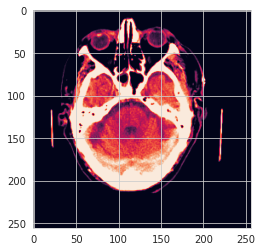

In [213]:
plt.imshow(plt.imread('../images/793d85d63.png'))

In [214]:
vgg19_model

MainModel(
  (feature): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (1

<module 'os' from '/usr/lib64/python3.7/os.py'>

'bf4ea9f53'

In [259]:
csv[csv['ID'] == df[110]]

,ID,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
2423,641b20893,1,0,1,0,1,0


In [265]:
# torch.sigmoid(dn201(transform('../images/641b20893.png')))>0.5
torch.sigmoid(resnet_model(transform('../images/641b20893.png')))


tensor([[9.9978e-01, 6.1086e-06, 9.9485e-01, 1.4240e-03, 8.3047e-01, 1.3441e-03]],
       grad_fn=<SigmoidBackward>)

In [266]:
print(9.9978e-01, 6.1086e-06, 9.9485e-01, 1.4240e-03, 8.3047e-01, 1.3441e-03])

SyntaxError: invalid syntax (<ipython-input-266-0b845e13dff9>, line 1)

In [263]:
torch.sigmoid(vgg19_model(transform('../images/641b20893.png')))>0.5

tensor([[ True, False,  True, False,  True, False]])